# Surface Analysis 

Script is written so date, time, and location input can be taken from the user when run as a .py file or 
can be input before the cell is run as a .ipynb file.

In [1]:
from datetime import datetime, timedelta
from netCDF4 import Dataset


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import glob

import numpy as np
import math


from netCDF4 import Dataset

import pandas as pd

from metpy.calc import reduce_point_density
import metpy.calc as mpcalc
from metpy.plots import StationPlot, wx_code_to_numeric
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.units import units
from metpy.interpolate import interpolate_to_grid, remove_nan_observations, interpolate_to_points
from metpy.io import metar


In [2]:
UNIX_TIME = datetime(1970,1,1,0)

### Date, time, and location

Here the user can input a date, time, latitude and longitude for the map to be plotted. 

In [3]:
#set time to plot (no leading zeros)
start_year  = 2019
start_month = 7
start_day   = 20
start_hour  = 0
start_min   = 0
    
#set plot domain
lat_min = 40
lat_max = 48
lon_min = -99
lon_max = -85

#calculate number of hours since date to plot
dt = datetime(start_year,start_month,start_day,start_hour,start_min)
del_t = datetime.now()-dt
del_t_days = del_t.days + (del_t.seconds/60/60/24)
del_t_hours = del_t_days * 24.

### Getting Data

Data is downladed and extracted either from MADIS data archived by NCEP (https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/archive/) or from recent MADIS data from NCEP (https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/point/metar/netcdf/). The URL is printed if user desires to download the raw data. Data is then placed into a dataset for processing in the next step.

In [4]:
#get the data
import requests
import gzip
import shutil

if del_t_hours>100:
    #download and extract the data
    base_url = 'https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/archive/'
    url = f'{base_url}{dt:%Y}/{dt:%m}/{dt:%d}/point/metar/netcdf/{dt:%Y%m%d_%H%M}.gz'

else:
    base_url = 'https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/point/metar/netcdf/'
    url = f'{base_url}{dt:%Y%m%d_%H%M}.gz'

print(url)

r = requests.get(url,allow_redirects=True)
open('temp.nc.gz','wb').write(r.content)
with gzip.open('temp.nc.gz','rb') as f_in:
    with open('temp.nc','wb') as f_out:
        shutil.copyfileobj(f_in,f_out)
data=Dataset('temp.nc','r')

https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/archive/2019/07/20/point/metar/netcdf/20190720_0000.gz


### Processing data

The data is processed, converted to station plots, and placed into a dataframe for trimming in the next step.

In [5]:
#sort data into variables
time = [UNIX_TIME + timedelta(seconds=float(t)) for t in data['timeNominal']]
lat = data['latitude'][:]
lat = lat.filled(np.nan)
lon = data['longitude'][:]
lon = lon.filled(np.nan)
temp = data['temperature'][:]
temp = temp.filled(np.nan)
temp[temp<100]=np.nan
temp = (temp-273.15)
dwpt = data['dewpoint'][:]
dwpt = dwpt.filled(np.nan)
dwpt[dwpt<100]=np.nan
dwpt = (dwpt-273.15)
wspd = data['windSpeed'][:]
wspd = wspd.filled(np.nan)
wspd[wspd>250] = np.nan
wdir = data['windDir'][:]
wdir = wdir.filled(np.nan)
wdir[wdir<0] = np.nan
gust = data['windGust'][:]
gust = gust.filled(np.nan)
gust[gust<0] = np.nan
pres = data['seaLevelPress'][:]/100.0
pres = pres.filled(np.nan)
name = data['stationName'][:]
name = [i.tostring().decode()[:4] for i in name]
sky_cov = data['skyCover'][:]
sky_cov = [(i[0].tostring().decode()).rstrip('\x00') for i in sky_cov]
sky_cvr = np.zeros(len(sky_cov),dtype=int)
clr_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="CLR"]
sky_cvr[clr_inds] = 0
few_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="FEW"]
sky_cvr[few_inds] = 2
sct_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="SCT"]
sky_cvr[sct_inds] = 4
bkn_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="BKN"]
sky_cvr[bkn_inds] = 6
ovc_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="OVC"]
sky_cvr[ovc_inds] = 8
wx = data['presWeather'][:]
pres_wx = np.zeros(len(lat))
wx = [(i.tostring().decode()).rstrip('\x00') for i in wx]
for i in range(len(wx)):
    this_wx = wx[i].split()
    if this_wx == []:
        pres_wx[i] = 0
        continue
    pres_wx[i] = wx_code_to_numeric(this_wx)[0]
pres_wx = pres_wx.astype(int)

#calculate u and v components of wind with MetPy
u,v = mpcalc.wind_components((wspd*units('m/s')).to('knots'),wdir*units.degree)

#place variables into dataframe to plot
df = pd.DataFrame(np.transpose(np.array([time,name,name,lon,lat,u,v,temp,dwpt,pres,sky_cvr,pres_wx])),
                      columns = ['time','id','name','lon','lat','u','v','temp','dwpt','pres','sky_cvr','wx'])
print(df)

/var/folders/06/psvnwwys3wb8jvz_dtrft5080000gn/T/ipykernel_54195/1977540682.py:27: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  name = [i.tostring().decode()[:4] for i in name]
/var/folders/06/psvnwwys3wb8jvz_dtrft5080000gn/T/ipykernel_54195/1977540682.py:29: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sky_cov = [(i[0].tostring().decode()).rstrip('\x00') for i in sky_cov]


           time    id  name         lon        lat          u          v  \
0    2019-07-20  NZCM  NZCM  166.970001 -77.870003       -0.0       -0.0   
1    2019-07-20  YMML  YMML  144.839996 -37.669998  -0.000004 -20.021599   
2    2019-07-20  SULS  SULS  -55.099998 -34.860001   0.506318  -2.871469   
3    2019-07-20  SUMU  SUMU       -56.0 -34.830002       -0.0       -0.0   
4    2019-07-20  YESP  YESP  121.809998     -33.68  14.967602       -0.0   
...         ...   ...   ...         ...        ...        ...        ...   
7788 2019-07-20  CWKD  CWKD  -71.019997      50.73    3.12705   2.623906   
7789 2019-07-20  CWDE  CWDE  -71.120003  51.549999  -0.708845   4.020057   
7790 2019-07-20  CWNQ  CWNQ  -72.650002  46.220001   5.122864   6.105192   
7791 2019-07-20  CWHQ  CWHQ  -71.949997      46.68   1.943844       -0.0   
7792 2019-07-20  CWDM  CWDM  -59.630001  50.470001   3.835894   1.396151   

           temp       dwpt         pres sky_cvr  wx  
0         -26.0      -30.0       

/var/folders/06/psvnwwys3wb8jvz_dtrft5080000gn/T/ipykernel_54195/1977540682.py:43: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  wx = [(i.tostring().decode()).rstrip('\x00') for i in wx]


### Trimming data

The data is trimmed to drop data outside of the latitude and longitude frame requested by the user. This is done to decrease computing time.

In [6]:
print('  drop data outside of domain')
to_drop = df[(df['lat'] > lat_max+10) | (df['lat'] < lat_min-10) | (df['lon'] > lon_max+10) | (df['lon'] < lon_min-10)].index
print('    dropped %i observations'%len(to_drop))
df_trim = df.drop(to_drop,inplace=False)
df_trim.set_index(['time','id'],inplace=True)

  drop data outside of domain
    dropped 4434 observations


### Analyzing Surface Pressure

There are two options to analyze surface pressure. The first is a single pass Cressman () analysis. The second is a multiple pass (successive corrections; ) analysis using the Cressman () weighting function. The multiple pass, successive corrections converges to observation values at the observation locations which can be desirable, but can also converge to error. While the single pass will only feature fine-scale or large-scale features based upon the search radius, the successive corrections will fit both fine-scale and large-scale features, but requires more computational overhead.

User input: Set if successive corrections are used, otherwise, provide a search radius (in meters).

In [7]:
successive_corrections = True
search_radius = 300000 #only used if successive_corrections is false

proj = ccrs.LambertConformal(central_latitude=(lat_min+lat_max) / 2,
                                     central_longitude=(lon_min+lon_max) / 2)

slpdf = df_trim.dropna(subset=['pres'],inplace=False)
    
point_locs = proj.transform_points(ccrs.PlateCarree(),df_trim['lon'].values,df_trim['lat'].values)
point_locs_slp = proj.transform_points(ccrs.PlateCarree(),slpdf['lon'].values,slpdf['lat'].values)

xp,yp,null = point_locs_slp.T
    
if successive_corrections:
    ROIs = [500000,400000,300000,200000]
    #first pass
    slpgridx, slpgridy, slp = interpolate_to_grid(xp,yp,slpdf['pres'],
                                              interp_type='cressman',
                                              minimum_neighbors=1,hres=20000,search_radius=ROIs[0])
    SLP = np.zeros((len(ROIs),len(slp),len(slp[0])))
    SLP[0] = slp
    grid = np.transpose([slpgridx.ravel(),slpgridy.ravel()])
    stns = np.transpose([xp,yp])
    for i in range(1,len(ROIs)):
        #interpolate gridded slp to obs locations:
        slp_bg = interpolate_to_points(grid,SLP[i-1].ravel(),stns,interp_type='cressman',search_radius=ROIs[i-1])
        
        #calculate next pass
        slpgridx, slpgridy, slp = interpolate_to_grid(xp,yp,slpdf['pres']-slp_bg,interp_type='cressman',minimum_neighbors=1,hres=20000,search_radius=ROIs[i])
        SLP[i] = np.nansum([slp,SLP[i-1]],axis=0)
        slp = SLP[i]
        
else:
    slpgridx, slpgridy, slp = interpolate_to_grid(xp,yp,slpdf['pres'],
                                              interp_type='cressman',
                                              minimum_neighbors=1,hres=20000,search_radius=search_radius)

### Plotting data

Data is plotted and a map is produced.

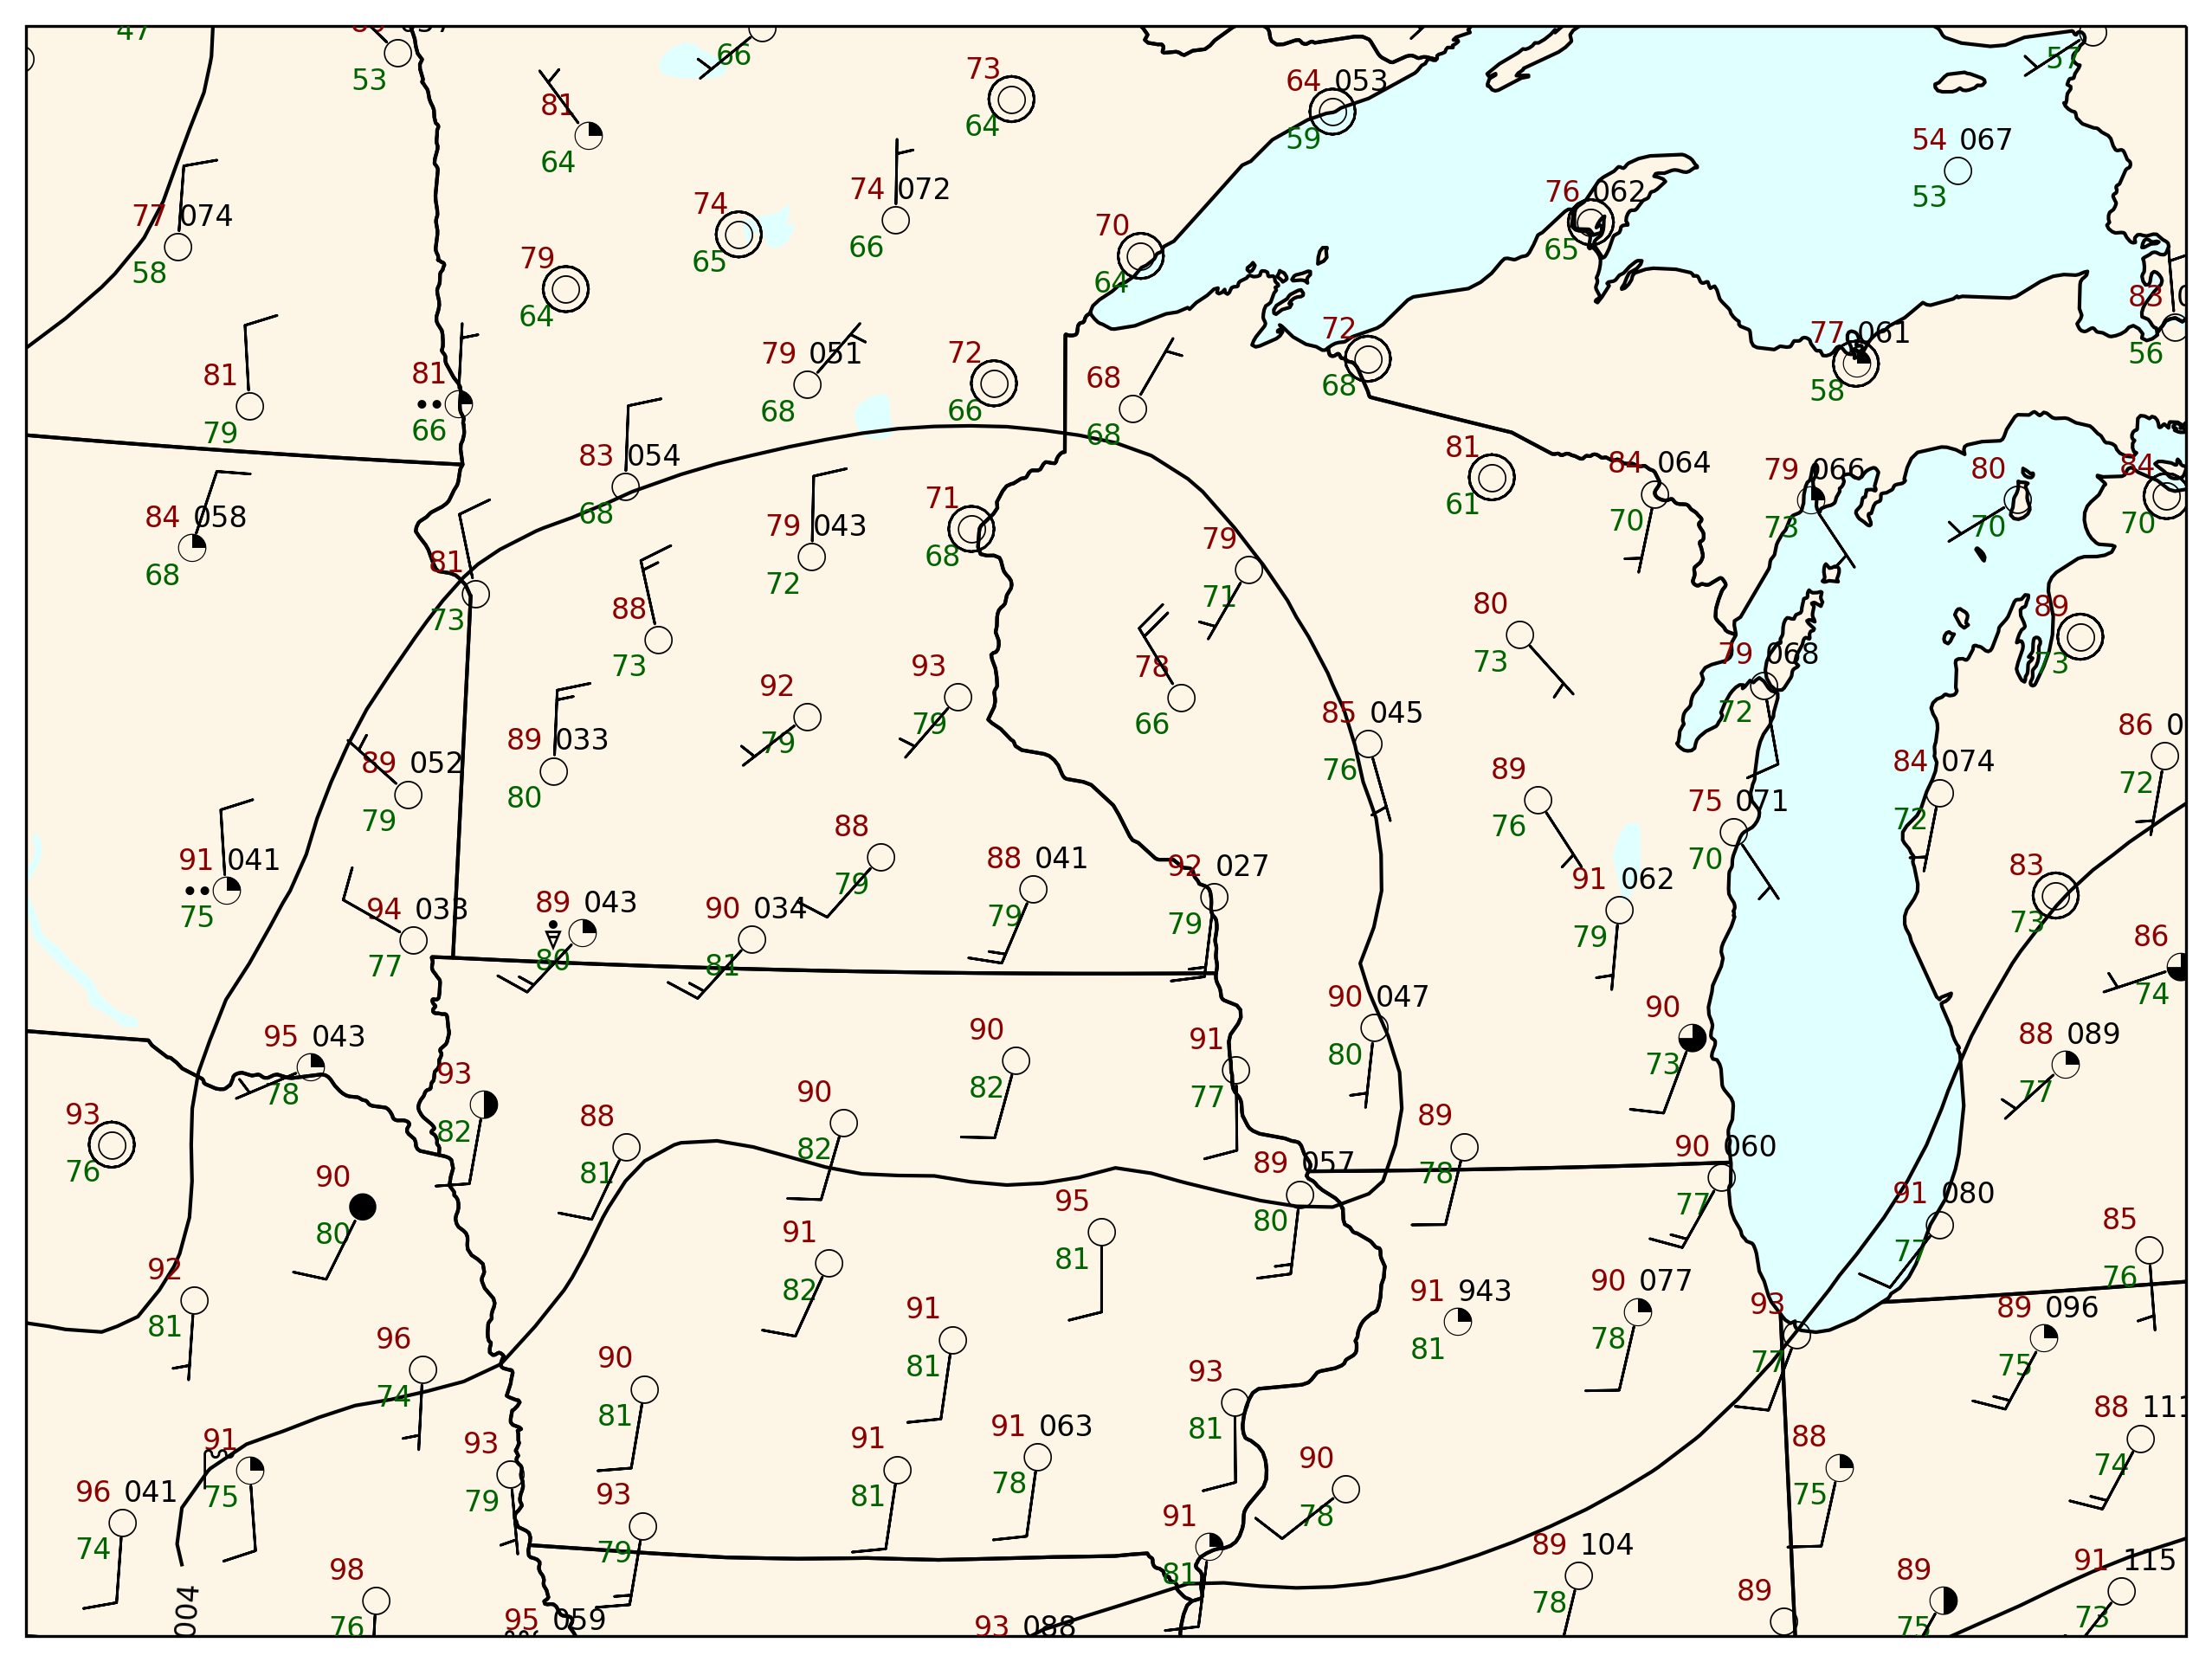

In [9]:
point_density = 75000.

df_plot = df_trim[reduce_point_density(point_locs,point_density)]
    
fig=plt.figure(figsize=(11,6.5),dpi=300)
ax = fig.add_subplot(1,1,1,projection=proj)
ax.add_feature(cfeature.NaturalEarthFeature('physical','land','50m',facecolor='oldlace'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','ocean','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','lakes','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

stationplot = StationPlot(ax,df_plot['lon'].values,df_plot['lat'].values,clip_on=True, transform=ccrs.PlateCarree(),fontsize=8)
stationplot.plot_parameter('NW',df_plot['temp']*(9.0/5.0)+32.0,color='darkred',fontsize=8)
stationplot.plot_parameter('NE',df_plot['pres'],color='black',formatter=lambda v: format(10 * v, '.0f')[-3:],fontsize=8)
stationplot.plot_parameter('SW',df_plot['dwpt']*(9.0/5.0)+32.0,color='darkgreen',fontsize=8)
stationplot.plot_barb(np.array(df_plot['u'].values,dtype=float),np.array(df_plot['v'].values,dtype=float),linewidth=0.7,length=6,zorder=10)
cs = plt.contour(slpgridx,slpgridy,slp,colors='k',levels=list(range(900,1046,4)),linewidths=1)
plt.clabel(cs, inline=1, fontsize=8, fmt='%i')
stationplot.plot_symbol('C',df['sky_cvr'].values,sky_cover)
stationplot.plot_symbol('W',df['wx'].values,current_weather,fontsize=12)
fig.tight_layout()
    
plt.show()